# CZ3005 Lab 2

In this assignment, you will use a real-world manufacturing dataset collected from the injection molding
dataset where this dataset is provided in your assignment folder. Fig. 1 exhibits the injection molding
machine. The injection molding machine is usually used to produce plastic trinkets, toys, water bottles,
containers, etc. The raw material, plastic, is injected through a nozzle into a mold cavity cooled and
hardened as per the layout of the cavity. In our case, the injection molding machine is used to produce
a transparent mold where the goal of this assignment is to build a neural network classifier to monitor
the quality of transparent mold. The monitoring process is performed using 48 input attributes
representing different machine parameters. 48 input attributes are outlined in Table 1. There exist two
common defects in the transparent mold: weaving and short-forming. This forms a three-class
classification problem. Fig. 2, 3, 4 respectively show the three product conditions: normal, weaving and
short forming. The challenge of this problem lies in its non-stationary characteristic because two
machine parameters, namely holding pressure and injection speed, are varied during the process runs.
Please check the refence for further details. 

### Task 1

You are asked to build a three-layer feed-forward neural network to solve the monitoring problem of
injection molding machine. Your implementation must be in Pytorch and executable in Google Colab
environments. The proportion of training and testing samples is 70:30 where your model must deliver
the smallest testing error possible. In that case, you need to select the number of nodes of hidden
layers, the number of epochs, the learning rates, the mini-batch size, etc. that lead to the smallest
testing error. In this assignment, you have to use the SGD optimizer as exemplified in the lab materials
under the mini-batch update fashion. The evaluation metric here is the classification error. No feature
selection is allowed here.

In [1]:
"""
Import Libraries
"""

import numpy as np
import matplotlib as plot
import matplotlib.pyplot as plt 
import scipy.io
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as d
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import seaborn as sns
import time
from scipy.signal import savgol_filter

In [2]:
"""
Global Constants
"""

SEED = 11
BATCH_SIZE = 128

input_size = 48
hidden_size_1 = 100
hidden_size_2 = 100
num_classes = 3

In [4]:
"""
Import Data

Only do this for Google Collab

Link followed: https://stackoverflow.com/questions/59622884/how-to-load-matlab-file-in-colab
Upload the OQC mat file into the ROOT directory of your google drive. If not it will not work.
"""

# from google.colab import drive
# import scipy.io

# drive.mount('/content/drive')

# data=scipy.io.loadmat('/content/drive/MyDrive/OQC.mat');
# print("Header information: {info}".format(info = data['__header__']))
# data = data['data']
# print("Length of Data: {length} data points".format(length = str(len(data))))

'\nImport Data\n\nOnly do this for Google Collab\n\nLink followed: https://stackoverflow.com/questions/59622884/how-to-load-matlab-file-in-colab\nUpload the OQC mat file into the ROOT directory of your google drive. If not it will not work.\n'

In [3]:
"""
Import Data

Do this when running Jupyter notebook locally
"""

data = scipy.io.loadmat(os.getcwd() + '/OQC.mat')
print("Header information: {info}".format(info = data['__header__']))
data = data['data']
print("Length of Data: {length} data points".format(length = str(len(data))))

Header information: b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Mar 29 14:29:37 2020'
Length of Data: 2952 data points


In [5]:
"""
Each data point has 49 values, and there are 48 input attributes.
Assume first 48 values in array [0, 47] are the input attributes.
Assume last data point in array [48] is the ouput attribute
"""

data[0]

array([3.90524727e-01, 1.47797582e-01, 1.56398104e-01, 2.55985544e-03,
       5.55555556e-01, 7.77777778e-01, 5.55555556e-01, 7.14285714e-01,
       5.00000000e-01, 5.00000000e-01, 0.00000000e+00, 0.00000000e+00,
       3.50680457e-01, 9.95993193e-01, 7.87486391e-01, 1.00000000e+00,
       4.37500000e-01, 3.75000000e-01, 1.00000000e+00, 3.33333333e-01,
       2.50000000e-01, 7.80247068e-02, 3.06230179e-01, 1.00000000e+00,
       5.00000000e-01, 6.66664707e-02, 6.93769821e-01, 6.14525149e-01,
       3.85474851e-01, 9.21936743e-01, 1.00000000e+00, 3.34645780e-02,
       4.99809148e-02, 2.33802826e-01, 1.00000000e+00, 9.80563469e-01,
       4.67564870e-01, 6.16027345e-01, 7.02833854e-02, 7.19864153e-01,
       3.72549020e-02, 3.29627376e-01, 1.00000000e+00, 3.76520200e-05,
       1.25000000e-01, 7.89695478e-02, 7.96252877e-02, 9.22469268e-01,
       2.00000000e+00])

In [6]:
"""
Helper functions:
extractcategoryfromdatapoint(data_point) -> extract the type of case [0, 1, 2]
extractdatafromdatapoint(data_point) -> extract the 48 inputs of the data point to be used for model training
"""

def extractcategoryfromdatapoint(data_point):
    return data_point[48]


def extractdatafromdatapoint(data_point):
    return data_point[0:48]

In [7]:
"""
From documentation, there is indeed 1008 good cases, 1074 weaving cases, and 870 short-forming cases 
"""

categories = np.array(list(map(extractcategoryfromdatapoint, data)))
int_categories = categories.astype(int)
np.bincount(int_categories)

array([1008, 1074,  870])

In [8]:
"""
Train test split function to split data randomly into 70:30 ratio
"""

train, test = train_test_split(data, test_size=0.3, random_state=SEED)
print("length of training data: " + str(len(train)))
print("length of testing data: " + str(len(test)))
print("total length of data: " + str(len(test)+ len(train)))

length of training data: 2066
length of testing data: 886
total length of data: 2952


In [9]:
"""
Further split the training data into training data and validation data in 90:10 using same train test split function
"""

train, validation = train_test_split(train, test_size=0.1, random_state=SEED)
print("length of training data: " + str(len(train)))
print("length of validation data: " + str(len(validation)))
print("total length of training data: " + str(len(validation)+ len(train)))

length of training data: 1859
length of validation data: 207
total length of training data: 2066


In [10]:
"""
Task 1
"""

class three_layer_forward_feed_neural_network(nn.Module):
    
    """
    Initialize a 3 layer forward feed neural network, extended from the pytorch neural network module
    
    layer1 -> input layer
    layer2 -> hidden layer
    layer3 -> output layer
    """
    def __init__(self, in_size, hidden_size_1, hidden_size_2, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, hidden_size_1)
        self.layer2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.layer3 = nn.Linear(hidden_size_2, out_size)
    
    """
    computes the output Tensor from the input Tensor in a forward pass. Between layers, relu() function is used
    to add non-linearity to our model which will be beneficial in raising accuracy levels

    Link on forward function: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
    Link on forward pass: https://stackoverflow.com/questions/36740533/what-are-forward-and-backward-passes-in-neural-networks
    Link on RELU and non-linearity: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
    """
    def forward(self, val):
        out = self.layer1(val)
        out = F.relu(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.layer3(out)
        return out
    
    """
    Function used to train the model. Takes the batch of training data, process it to extract the labels
    from the actual 48 inputs. Generate an output prediction from that batch before calculating the loss/
    cost function incurred via cross entropy. Loss is returned.
    """
    def training_step(self, batch):
        forty_eight_inputs = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist() for i in batch]).type(torch.LongTensor)
        out = self(forty_eight_inputs) 
        loss = F.cross_entropy(out, labels) 
        return loss
    
    """
    Function used to validate the model during training. Takes the batch of training data, process it to 
    extract the labels from the actual 48 inputs. Generate an output prediction from that batch before 
    calculating the loss/cost function incurred via cross entropy. Loss is returned.
    """
    def validation_step(self, batch):
        images = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist()  for i in batch]).type(torch.LongTensor)
        out = self(images) 
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)           
        return {'val_loss': loss, 'val_acc': acc}
        
    """
    Calculate the average accuracy and loss per epoch using the accuracy and loss from the entire batch respectively
    """    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    """
    Function used to print out the validation loss and validation accuracy of an epoch
    """
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [11]:
"""
Get the accuracy of the model using the predicted values and the labels
"""
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


"""
Evaluate the model's performance on the validation set
"""
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


"""
Extract model accuracy from list of history records
"""
def extractmodelaccuracy(n):
    return n['val_acc']


"""
Extract model loss from list of history records
"""
def extractmodelloss(n):
    return n['val_loss']


"""
Train the model using gradient descent
"""
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, average_acc = [], average_loss = [], time_taken = []):
    start_time = time.time()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    print("Average model loss during fitting: {val}".format(val=str(sum(map(extractmodelloss, history))/len(history))))
    print("Average model accuracy during fitting: {val}".format(val=str(sum(map(extractmodelaccuracy, history))/len(history))))
    print("Time taken to fit: {val}".format(val=time.time() - start_time))
    average_acc.append(sum(map(extractmodelaccuracy, history))/len(history)) 
    average_loss.append(sum(map(extractmodelloss, history))/len(history)) 
    time_taken.append(time.time()-start_time)
    return history

In [12]:
"""
Reset following values for easy configuration of base values
"""

input_size = 48
hidden_size = 300
num_classes = 3

In [13]:
"""
Load training and validation data in batches (don't want to train and validate our model using the entire
set of training and validation data)

If you encounter `Runtime Error with DataLoader: exited unexpectedly`, set num_workers to 0
https://github.com/pytorch/pytorch/issues/5301
"""

train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
model = three_layer_forward_feed_neural_network(input_size, hidden_size, hidden_size, num_classes)

In [14]:
"""
Validate model
"""

history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.105758547782898, 'val_acc': 0.25120773911476135}]

In [15]:
"""
Train and validate model using 50 epochs and 0.5 learning rate
"""

history += fit(20, 0.2, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0191, val_acc: 0.6522
Epoch [1], val_loss: 0.8877, val_acc: 0.4734
Epoch [2], val_loss: 0.8521, val_acc: 0.5362
Epoch [3], val_loss: 0.7465, val_acc: 0.5507
Epoch [4], val_loss: 0.4899, val_acc: 0.9227
Epoch [5], val_loss: 0.4172, val_acc: 0.9179
Epoch [6], val_loss: 0.3539, val_acc: 0.9130
Epoch [7], val_loss: 0.3676, val_acc: 0.9372
Epoch [8], val_loss: 0.4625, val_acc: 0.8792
Epoch [9], val_loss: 0.3180, val_acc: 0.8647
Epoch [10], val_loss: 0.1866, val_acc: 0.9614
Epoch [11], val_loss: 0.3711, val_acc: 0.9469
Epoch [12], val_loss: 0.3362, val_acc: 0.8647
Epoch [13], val_loss: 0.2153, val_acc: 0.9130
Epoch [14], val_loss: 0.1329, val_acc: 0.9662
Epoch [15], val_loss: 0.1298, val_acc: 0.9614
Epoch [16], val_loss: 0.1098, val_acc: 0.9758
Epoch [17], val_loss: 0.2083, val_acc: 0.9372
Epoch [18], val_loss: 0.1479, val_acc: 0.9662
Epoch [19], val_loss: 0.1243, val_acc: 0.9614
Average model loss during fitting: 0.39382889606058596
Average model accuracy during fitti

In [16]:
"""
Test model using testset
"""

test_loader = DataLoader(test, batch_size=200)
result = evaluate(model, test_loader)
result

{'val_loss': 0.1556914746761322, 'val_acc': 0.9403488039970398}

In [17]:
"""
Configure size for seaborn plot
"""

sns.set(rc={'figure.figsize':(10,4)})

Train set accuracy: 0.935449166218397


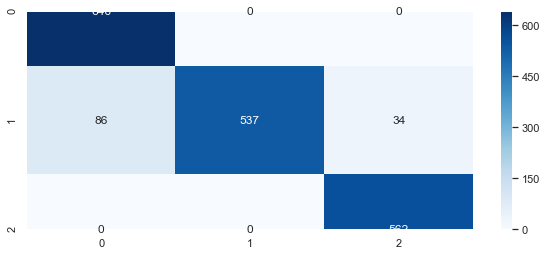

In [18]:
"""
Accuracy score: (TN + TP)/(TP + TN + FN + FP)

Seaborn visualization guide: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
Seaborn plot size: https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
"""

train_actual = []
train_pred = []

for i in train:
    train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    train_actual.append(int(i[48]))
    
print("Train set accuracy: " + str(accuracy_score(train_actual, train_pred)))    

cf_trainset_matrix = confusion_matrix(train_actual, train_pred)
sns.heatmap(cf_trainset_matrix, annot=True, cmap='Blues', fmt='g')

Test set accuracy: 0.9356659142212189


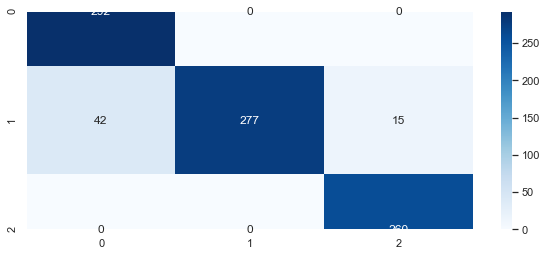

In [19]:
test_actual = []
test_pred = []

for i in test:
    test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    test_actual.append(int(i[48]))
    
print("Test set accuracy: " + str(accuracy_score(test_actual, test_pred)))

cf_testset_matrix = confusion_matrix(test_actual, test_pred)
sns.heatmap(cf_testset_matrix, annot=True, cmap='Blues', fmt='g')

### Task 2 (Hidden Nodes & Layers)

You are asked to study the effect of network structure: hidden nodes, hidden layers to the classification
performance. That is, you try different network configurations and understand the patterns. Your
experiments have to be well-documented in your Jupyter notebook file and your report. It has to cover
different aspects of network configurations such as shallow network, wide network, deep network etc.

Note that your analysis should touch the issue of accuracy as well as complexity for task 2-4. The
complexity can be defined in the context of execution time. 

In [20]:
"""
Effect of number of hidden nodes of 3 layer forward feed network
Iterate through from 1 node hidden layer to 100 node hidden layer and observe
"""

input_size = 48
hidden_size = 100
num_classes = 3

time_to_train_model = []
average_model_validation_accuracy = []
average_model_validation_loss = []
model_test_accuracy = []
model_train_accuracy = []


for i in range (1, 101):
    history = []
    train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
    model = three_layer_forward_feed_neural_network(input_size, i, i, num_classes)
    history += fit(20, 0.1, model, train_loader, val_loader, average_acc = average_model_validation_accuracy, average_loss = average_model_validation_loss, time_taken = time_to_train_model)

    
    train_actual = []
    train_pred = []

    for i in train:
        train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        train_actual.append(int(i[48]))
        
    model_train_accuracy.append(str(accuracy_score(train_actual, train_pred)))   
    
    test_actual = []
    test_pred = []

    for i in test:
        test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        test_actual.append(int(i[48]))

    model_test_accuracy.append(str(accuracy_score(test_actual, test_pred)))      

Epoch [0], val_loss: 1.1897, val_acc: 0.2319
Epoch [1], val_loss: 1.1351, val_acc: 0.2319
Epoch [2], val_loss: 1.1087, val_acc: 0.4010
Epoch [3], val_loss: 1.0956, val_acc: 0.4058
Epoch [4], val_loss: 1.0908, val_acc: 0.3382
Epoch [5], val_loss: 1.0599, val_acc: 0.3913
Epoch [6], val_loss: 1.0273, val_acc: 0.4638
Epoch [7], val_loss: 0.9838, val_acc: 0.7246
Epoch [8], val_loss: 0.9262, val_acc: 0.7198
Epoch [9], val_loss: 0.9028, val_acc: 0.5266
Epoch [10], val_loss: 0.8114, val_acc: 0.6908
Epoch [11], val_loss: 0.7574, val_acc: 0.7101
Epoch [12], val_loss: 0.7001, val_acc: 0.8213
Epoch [13], val_loss: 0.7550, val_acc: 0.5797
Epoch [14], val_loss: 0.6639, val_acc: 0.6618
Epoch [15], val_loss: 0.6435, val_acc: 0.6763
Epoch [16], val_loss: 0.5683, val_acc: 0.8406
Epoch [17], val_loss: 0.5437, val_acc: 0.8406
Epoch [18], val_loss: 0.6657, val_acc: 0.6860
Epoch [19], val_loss: 0.4824, val_acc: 0.9179
Average model loss during fitting: 0.8555658534169197
Average model accuracy during fittin

Epoch [19], val_loss: 0.3261, val_acc: 0.8889
Average model loss during fitting: 0.7727256998419761
Average model accuracy during fitting: 0.653864735364914
Time taken to fit: 1.8271369934082031
Epoch [0], val_loss: 1.0788, val_acc: 0.4010
Epoch [1], val_loss: 1.0695, val_acc: 0.4010
Epoch [2], val_loss: 1.0595, val_acc: 0.4010
Epoch [3], val_loss: 1.0475, val_acc: 0.5266
Epoch [4], val_loss: 1.0271, val_acc: 0.7005
Epoch [5], val_loss: 0.9840, val_acc: 0.7729
Epoch [6], val_loss: 0.9147, val_acc: 0.7198
Epoch [7], val_loss: 0.8538, val_acc: 0.7633
Epoch [8], val_loss: 0.7406, val_acc: 0.7198
Epoch [9], val_loss: 0.7279, val_acc: 0.7246
Epoch [10], val_loss: 0.7002, val_acc: 0.5845
Epoch [11], val_loss: 0.7083, val_acc: 0.6280
Epoch [12], val_loss: 0.4846, val_acc: 0.9130
Epoch [13], val_loss: 0.5515, val_acc: 0.8019
Epoch [14], val_loss: 0.4728, val_acc: 0.8309
Epoch [15], val_loss: 0.7466, val_acc: 0.5749
Epoch [16], val_loss: 0.5013, val_acc: 0.7874
Epoch [17], val_loss: 0.3364, val

Epoch [14], val_loss: 0.6038, val_acc: 0.8841
Epoch [15], val_loss: 0.5727, val_acc: 0.7681
Epoch [16], val_loss: 1.0021, val_acc: 0.3188
Epoch [17], val_loss: 0.6045, val_acc: 0.7150
Epoch [18], val_loss: 0.8700, val_acc: 0.4010
Epoch [19], val_loss: 0.3420, val_acc: 0.9420
Average model loss during fitting: 0.8893265306949616
Average model accuracy during fitting: 0.6019323721528054
Time taken to fit: 6.6118340492248535
Epoch [0], val_loss: 1.0874, val_acc: 0.3671
Epoch [1], val_loss: 1.0782, val_acc: 0.4348
Epoch [2], val_loss: 1.0713, val_acc: 0.5990
Epoch [3], val_loss: 1.0667, val_acc: 0.5556
Epoch [4], val_loss: 1.0550, val_acc: 0.6329
Epoch [5], val_loss: 1.0351, val_acc: 0.6715
Epoch [6], val_loss: 1.0014, val_acc: 0.7246
Epoch [7], val_loss: 0.9505, val_acc: 0.8164
Epoch [8], val_loss: 0.8729, val_acc: 0.7585
Epoch [9], val_loss: 0.8020, val_acc: 0.7150
Epoch [10], val_loss: 0.7274, val_acc: 0.7343
Epoch [11], val_loss: 0.6118, val_acc: 0.8696
Epoch [12], val_loss: 0.6406, va

Epoch [8], val_loss: 0.6624, val_acc: 0.8357
Epoch [9], val_loss: 0.5840, val_acc: 0.8019
Epoch [10], val_loss: 0.6974, val_acc: 0.6232
Epoch [11], val_loss: 0.7007, val_acc: 0.5314
Epoch [12], val_loss: 0.4977, val_acc: 0.8116
Epoch [13], val_loss: 0.4095, val_acc: 0.9130
Epoch [14], val_loss: 0.4831, val_acc: 0.8261
Epoch [15], val_loss: 0.5114, val_acc: 0.7391
Epoch [16], val_loss: 0.3390, val_acc: 0.8937
Epoch [17], val_loss: 0.3449, val_acc: 0.9372
Epoch [18], val_loss: 0.5015, val_acc: 0.7536
Epoch [19], val_loss: 0.4384, val_acc: 0.8019
Average model loss during fitting: 0.702169731259346
Average model accuracy during fitting: 0.6975845411419869
Time taken to fit: 4.268722295761108
Epoch [0], val_loss: 1.0782, val_acc: 0.4783
Epoch [1], val_loss: 1.0710, val_acc: 0.5604
Epoch [2], val_loss: 1.0596, val_acc: 0.4734
Epoch [3], val_loss: 1.0399, val_acc: 0.7101
Epoch [4], val_loss: 1.0076, val_acc: 0.7295
Epoch [5], val_loss: 0.9499, val_acc: 0.6908
Epoch [6], val_loss: 0.8557, val

Epoch [4], val_loss: 0.9856, val_acc: 0.8744
Epoch [5], val_loss: 0.8977, val_acc: 0.6763
Epoch [6], val_loss: 0.7846, val_acc: 0.7536
Epoch [7], val_loss: 0.6730, val_acc: 0.7778
Epoch [8], val_loss: 0.6374, val_acc: 0.8019
Epoch [9], val_loss: 0.5332, val_acc: 0.8406
Epoch [10], val_loss: 1.1016, val_acc: 0.3043
Epoch [11], val_loss: 0.4078, val_acc: 0.9130
Epoch [12], val_loss: 0.9857, val_acc: 0.4348
Epoch [13], val_loss: 0.3931, val_acc: 0.8792
Epoch [14], val_loss: 0.4586, val_acc: 0.8068
Epoch [15], val_loss: 0.6109, val_acc: 0.6715
Epoch [16], val_loss: 0.3325, val_acc: 0.8889
Epoch [17], val_loss: 0.5746, val_acc: 0.6812
Epoch [18], val_loss: 0.4209, val_acc: 0.8068
Epoch [19], val_loss: 0.4082, val_acc: 0.7971
Average model loss during fitting: 0.721542303264141
Average model accuracy during fitting: 0.6857487916946411
Time taken to fit: 1.2065870761871338
Epoch [0], val_loss: 1.0927, val_acc: 0.4251
Epoch [1], val_loss: 1.0745, val_acc: 0.4106
Epoch [2], val_loss: 1.0600, va

Epoch [0], val_loss: 1.0834, val_acc: 0.5411
Epoch [1], val_loss: 1.0754, val_acc: 0.5749
Epoch [2], val_loss: 1.0641, val_acc: 0.5845
Epoch [3], val_loss: 1.0512, val_acc: 0.6473
Epoch [4], val_loss: 1.0293, val_acc: 0.5604
Epoch [5], val_loss: 0.9919, val_acc: 0.5604
Epoch [6], val_loss: 0.9328, val_acc: 0.8599
Epoch [7], val_loss: 0.8249, val_acc: 0.7874
Epoch [8], val_loss: 0.7080, val_acc: 0.7923
Epoch [9], val_loss: 0.6007, val_acc: 0.8551
Epoch [10], val_loss: 0.8481, val_acc: 0.4300
Epoch [11], val_loss: 0.4870, val_acc: 0.8696
Epoch [12], val_loss: 0.4301, val_acc: 0.9034
Epoch [13], val_loss: 0.4386, val_acc: 0.8889
Epoch [14], val_loss: 0.4195, val_acc: 0.8792
Epoch [15], val_loss: 0.6656, val_acc: 0.6135
Epoch [16], val_loss: 0.5689, val_acc: 0.6860
Epoch [17], val_loss: 0.3841, val_acc: 0.8502
Epoch [18], val_loss: 0.2883, val_acc: 0.8986
Epoch [19], val_loss: 0.3570, val_acc: 0.8454
Average model loss during fitting: 0.7124493390321731
Average model accuracy during fittin

Epoch [19], val_loss: 0.1985, val_acc: 0.9324
Average model loss during fitting: 0.669810450822115
Average model accuracy during fitting: 0.7314009666442871
Time taken to fit: 5.587418794631958
Epoch [0], val_loss: 1.0810, val_acc: 0.5652
Epoch [1], val_loss: 1.0744, val_acc: 0.6570
Epoch [2], val_loss: 1.0654, val_acc: 0.5894
Epoch [3], val_loss: 1.0539, val_acc: 0.5411
Epoch [4], val_loss: 1.0328, val_acc: 0.6908
Epoch [5], val_loss: 0.9957, val_acc: 0.5797
Epoch [6], val_loss: 0.9278, val_acc: 0.7246
Epoch [7], val_loss: 0.8273, val_acc: 0.6957
Epoch [8], val_loss: 0.7175, val_acc: 0.7971
Epoch [9], val_loss: 0.5900, val_acc: 0.8454
Epoch [10], val_loss: 0.8161, val_acc: 0.4686
Epoch [11], val_loss: 0.4627, val_acc: 0.8937
Epoch [12], val_loss: 0.9222, val_acc: 0.3816
Epoch [13], val_loss: 0.9611, val_acc: 0.3623
Epoch [14], val_loss: 0.3435, val_acc: 0.9034
Epoch [15], val_loss: 0.3284, val_acc: 0.9324
Epoch [16], val_loss: 0.4008, val_acc: 0.8551
Epoch [17], val_loss: 0.2786, val_

Epoch [14], val_loss: 0.3700, val_acc: 0.8937
Epoch [15], val_loss: 0.6098, val_acc: 0.6473
Epoch [16], val_loss: 0.3354, val_acc: 0.8937
Epoch [17], val_loss: 0.2611, val_acc: 0.9469
Epoch [18], val_loss: 0.2343, val_acc: 0.9130
Epoch [19], val_loss: 0.2219, val_acc: 0.9130
Average model loss during fitting: 0.6345881283283233
Average model accuracy during fitting: 0.7265700548887253
Time taken to fit: 4.193440914154053
Epoch [0], val_loss: 1.0804, val_acc: 0.4010
Epoch [1], val_loss: 1.0656, val_acc: 0.5121
Epoch [2], val_loss: 1.0492, val_acc: 0.5314
Epoch [3], val_loss: 1.0263, val_acc: 0.5700
Epoch [4], val_loss: 0.9741, val_acc: 0.6135
Epoch [5], val_loss: 0.9031, val_acc: 0.7343
Epoch [6], val_loss: 0.8081, val_acc: 0.7826
Epoch [7], val_loss: 0.8434, val_acc: 0.3961
Epoch [8], val_loss: 0.5866, val_acc: 0.8551
Epoch [9], val_loss: 0.6111, val_acc: 0.6377
Epoch [10], val_loss: 0.6950, val_acc: 0.5990
Epoch [11], val_loss: 0.5554, val_acc: 0.7101
Epoch [12], val_loss: 0.4239, val

Epoch [11], val_loss: 0.3260, val_acc: 0.9179
Epoch [12], val_loss: 0.4200, val_acc: 0.8792
Epoch [13], val_loss: 0.2775, val_acc: 0.9565
Epoch [14], val_loss: 0.2632, val_acc: 0.9565
Epoch [15], val_loss: 0.2903, val_acc: 0.9082
Epoch [16], val_loss: 0.2913, val_acc: 0.8841
Epoch [17], val_loss: 0.2023, val_acc: 0.9614
Epoch [18], val_loss: 0.4870, val_acc: 0.7440
Epoch [19], val_loss: 0.2243, val_acc: 0.9227
Average model loss during fitting: 0.6295865207910538
Average model accuracy during fitting: 0.7657004833221436
Time taken to fit: 1.3858058452606201
Epoch [0], val_loss: 1.0887, val_acc: 0.4010
Epoch [1], val_loss: 1.0795, val_acc: 0.4106
Epoch [2], val_loss: 1.0749, val_acc: 0.5845
Epoch [3], val_loss: 1.0622, val_acc: 0.6425
Epoch [4], val_loss: 1.0455, val_acc: 0.6329
Epoch [5], val_loss: 1.0177, val_acc: 0.7488
Epoch [6], val_loss: 0.9667, val_acc: 0.5749
Epoch [7], val_loss: 0.8724, val_acc: 0.7681
Epoch [8], val_loss: 0.7578, val_acc: 0.7101
Epoch [9], val_loss: 0.7184, va

Epoch [5], val_loss: 0.9803, val_acc: 0.7585
Epoch [6], val_loss: 0.9036, val_acc: 0.7440
Epoch [7], val_loss: 0.8546, val_acc: 0.6377
Epoch [8], val_loss: 0.7362, val_acc: 0.5556
Epoch [9], val_loss: 0.5658, val_acc: 0.8744
Epoch [10], val_loss: 0.5038, val_acc: 0.9130
Epoch [11], val_loss: 1.3232, val_acc: 0.2657
Epoch [12], val_loss: 0.5789, val_acc: 0.6908
Epoch [13], val_loss: 0.3585, val_acc: 0.9469
Epoch [14], val_loss: 0.3046, val_acc: 0.9179
Epoch [15], val_loss: 0.4990, val_acc: 0.7488
Epoch [16], val_loss: 0.4111, val_acc: 0.8454
Epoch [17], val_loss: 0.2660, val_acc: 0.9227
Epoch [18], val_loss: 0.6259, val_acc: 0.6425
Epoch [19], val_loss: 0.2349, val_acc: 0.9130
Average model loss during fitting: 0.7216548293828964
Average model accuracy during fitting: 0.6949275404214859
Time taken to fit: 5.4160802364349365
Epoch [0], val_loss: 1.0798, val_acc: 0.5169
Epoch [1], val_loss: 1.0650, val_acc: 0.5362
Epoch [2], val_loss: 1.0509, val_acc: 0.5942
Epoch [3], val_loss: 1.0243, v

Epoch [0], val_loss: 1.0756, val_acc: 0.4444
Epoch [1], val_loss: 1.0626, val_acc: 0.5121
Epoch [2], val_loss: 1.0512, val_acc: 0.5942
Epoch [3], val_loss: 1.0161, val_acc: 0.6473
Epoch [4], val_loss: 0.9680, val_acc: 0.7729
Epoch [5], val_loss: 0.8812, val_acc: 0.7826
Epoch [6], val_loss: 0.7470, val_acc: 0.8502
Epoch [7], val_loss: 0.7283, val_acc: 0.5507
Epoch [8], val_loss: 0.7491, val_acc: 0.5797
Epoch [9], val_loss: 0.5306, val_acc: 0.8551
Epoch [10], val_loss: 0.4105, val_acc: 0.9179
Epoch [11], val_loss: 0.8295, val_acc: 0.4879
Epoch [12], val_loss: 0.3760, val_acc: 0.8937
Epoch [13], val_loss: 0.8673, val_acc: 0.5217
Epoch [14], val_loss: 0.2917, val_acc: 0.9372
Epoch [15], val_loss: 0.3177, val_acc: 0.8937
Epoch [16], val_loss: 0.2185, val_acc: 0.9420
Epoch [17], val_loss: 0.4487, val_acc: 0.7971
Epoch [18], val_loss: 0.2043, val_acc: 0.9324
Epoch [19], val_loss: 0.7172, val_acc: 0.5990
Average model loss during fitting: 0.6745707243680954
Average model accuracy during fittin

Epoch [18], val_loss: 0.2070, val_acc: 0.9517
Epoch [19], val_loss: 0.2815, val_acc: 0.8744
Average model loss during fitting: 0.6442531645298004
Average model accuracy during fitting: 0.7533816382288933
Time taken to fit: 1.6326661109924316
Epoch [0], val_loss: 1.0847, val_acc: 0.3671
Epoch [1], val_loss: 1.0697, val_acc: 0.5266
Epoch [2], val_loss: 1.0528, val_acc: 0.5700
Epoch [3], val_loss: 1.0254, val_acc: 0.6280
Epoch [4], val_loss: 0.9874, val_acc: 0.7391
Epoch [5], val_loss: 0.9102, val_acc: 0.8551
Epoch [6], val_loss: 0.7905, val_acc: 0.8792
Epoch [7], val_loss: 0.6613, val_acc: 0.8986
Epoch [8], val_loss: 0.5537, val_acc: 0.8937
Epoch [9], val_loss: 0.7086, val_acc: 0.5797
Epoch [10], val_loss: 0.4329, val_acc: 0.8841
Epoch [11], val_loss: 0.4190, val_acc: 0.9034
Epoch [12], val_loss: 0.3807, val_acc: 0.9082
Epoch [13], val_loss: 0.4434, val_acc: 0.8019
Epoch [14], val_loss: 0.3242, val_acc: 0.9324
Epoch [15], val_loss: 0.2570, val_acc: 0.9275
Epoch [16], val_loss: 0.6234, va

Epoch [12], val_loss: 0.3688, val_acc: 0.9275
Epoch [13], val_loss: 0.7939, val_acc: 0.5845
Epoch [14], val_loss: 0.3199, val_acc: 0.9227
Epoch [15], val_loss: 0.4692, val_acc: 0.7633
Epoch [16], val_loss: 0.2332, val_acc: 0.9420
Epoch [17], val_loss: 0.2286, val_acc: 0.9179
Epoch [18], val_loss: 1.0291, val_acc: 0.4686
Epoch [19], val_loss: 0.2790, val_acc: 0.8599
Average model loss during fitting: 0.6975785881280899
Average model accuracy during fitting: 0.6775362357497215
Time taken to fit: 2.3654682636260986
Epoch [0], val_loss: 1.0830, val_acc: 0.4106
Epoch [1], val_loss: 1.0708, val_acc: 0.5072
Epoch [2], val_loss: 1.0469, val_acc: 0.5217
Epoch [3], val_loss: 1.0156, val_acc: 0.6957
Epoch [4], val_loss: 0.9599, val_acc: 0.7295
Epoch [5], val_loss: 0.8545, val_acc: 0.7246
Epoch [6], val_loss: 0.7195, val_acc: 0.7681
Epoch [7], val_loss: 0.7270, val_acc: 0.6473
Epoch [8], val_loss: 0.6515, val_acc: 0.5990
Epoch [9], val_loss: 0.5820, val_acc: 0.6957
Epoch [10], val_loss: 0.4529, va

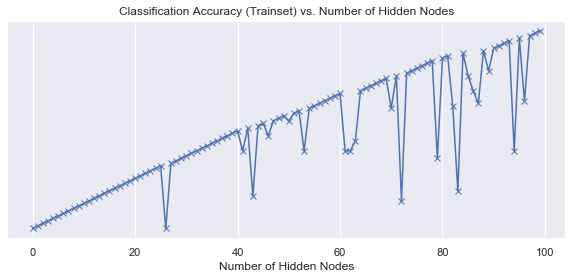

In [21]:
"""
https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib
https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
"""

plt.plot(model_train_accuracy, '-x')
ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy (Trainset) vs. Number of Hidden Nodes');
plt.show()

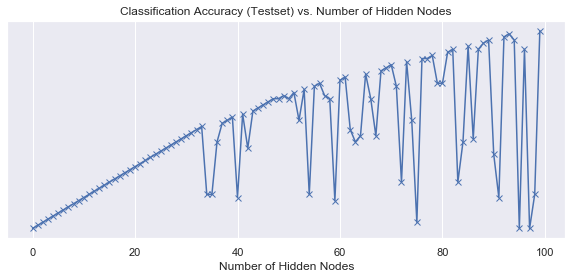

In [22]:
plt.plot(model_test_accuracy, '-x')
ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy (Testset) vs. Number of Hidden Nodes');
plt.show()

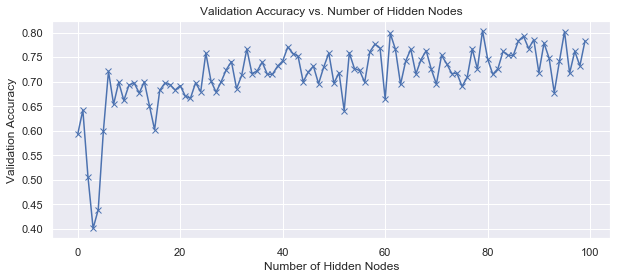

In [23]:
plt.plot(average_model_validation_accuracy, '-x')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Hidden Nodes');
plt.show()

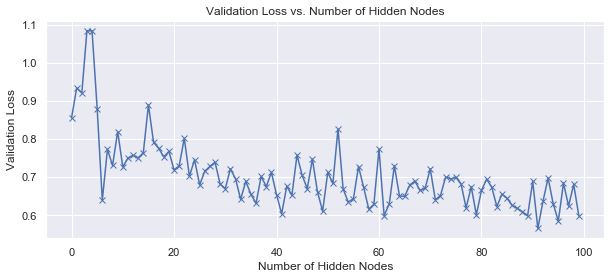

In [24]:
plt.plot(average_model_validation_loss, '-x')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Hidden Nodes');
plt.show()

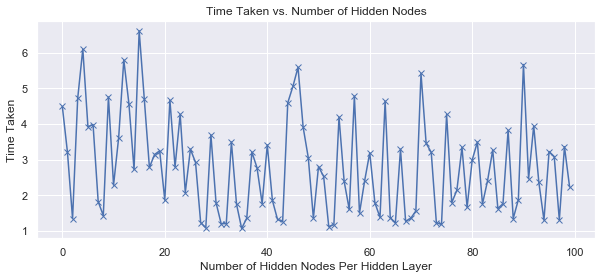

In [25]:
plt.plot(time_to_train_model, '-x')
plt.xlabel('Number of Hidden Nodes Per Hidden Layer')
plt.ylabel('Time Taken')
plt.title('Time Taken vs. Number of Hidden Nodes');
plt.show()

### Use Savitzky–Golay filter to smoothen curve and observe trend

explanation for random spikes due to mini-batching: https://stats.stackexchange.com/questions/303857/explanation-of-spikes-in-training-loss-vs-iterations-with-adam-optimizer

credits: https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

credits: https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

### Spikes in graphs:

Earlier from the above graphs, we observed irregular spikes in the various metrics we were analysizing and observing (e.g. average validation accuracy, averahe validation loss) and our hypothesis is that the reason for these spikes to surface in our graphs is due to mini-batching gradient descent - that particular batch of data which was use to train and fit the model received "bad data" and hence performed poorly. Using Stochastic Gradient Descent would most likely behave in a similar fashion given that now it is using a single data point to train and validate the model for every epoch albeit not as drastically as mini batch gradient descent. A possible solution is to simply use the entire dataset (batch gradient descent) for model training and validation for every epoch. Hence apart from complexity and accuracy, we will verify this subsequently.

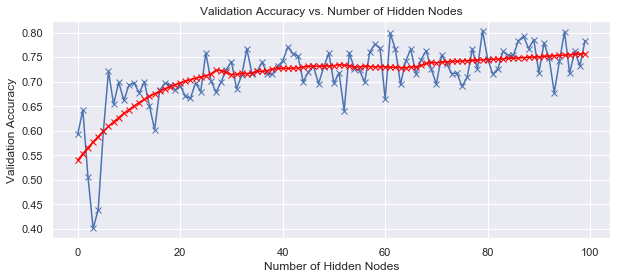

In [26]:
yhat = savgol_filter(average_model_validation_accuracy, 51, 3) 
plt.plot(average_model_validation_accuracy, '-x')
plt.plot(yhat, '-x', color='red')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Hidden Nodes');
plt.show()

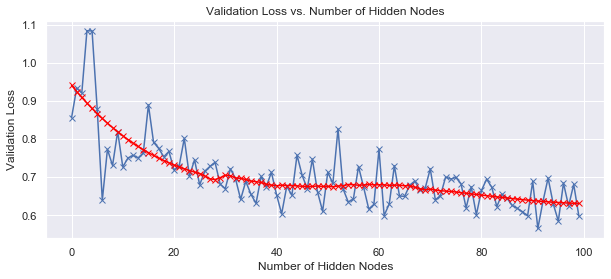

In [27]:
yhat = savgol_filter(average_model_validation_loss, 51, 3) 
plt.plot(average_model_validation_loss, '-x')
plt.plot(yhat, '-x', color='red')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Hidden Nodes');
plt.show()

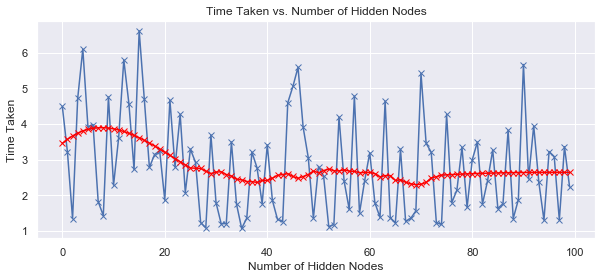

In [28]:
yhat = savgol_filter(time_to_train_model, 51, 3) 
plt.plot(time_to_train_model, '-x')
plt.plot(yhat, '-x', color='red')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Time Taken')
plt.title('Time Taken vs. Number of Hidden Nodes');
plt.show()

In [29]:
"""
Effect of number of hidden layers nodes of n layer forward feed network
Iterate through 1 layer hidden node, 3 layer hidden node, 5 layer hidden node 
and 10 layer hidden node neural network, all with 100 nodes per layer
"""

input_size = 48
hidden_size = 100
num_classes = 3

compile_avg_model_loss = []
compile_avg_model_acc = []
compile_model_trainset_acc = []
compile_model_testset_acc = []
compile_model_time_to_train = []

class one_layer(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, out_size)


    def forward(self, val):
        out = self.layer1(val)
        return out


    def training_step(self, batch):
        forty_eight_inputs = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist() for i in batch]).type(torch.LongTensor)
        out = self(forty_eight_inputs) 
        loss = F.cross_entropy(out, labels) 
        return loss


    def validation_step(self, batch):
        images = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist()  for i in batch]).type(torch.LongTensor)
        out = self(images) 
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)           
        return {'val_loss': loss, 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


class three_layer(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, out_size)


    def forward(self, val):
        out = self.layer1(val)
        out = F.relu(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.layer3(out)
        return out


    def training_step(self, batch):
        forty_eight_inputs = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist() for i in batch]).type(torch.LongTensor)
        out = self(forty_eight_inputs) 
        loss = F.cross_entropy(out, labels) 
        return loss


    def validation_step(self, batch):
        images = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist()  for i in batch]).type(torch.LongTensor)
        out = self(images) 
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)           
        return {'val_loss': loss, 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

class five_layer(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, out_size)


    def forward(self, val):
        out = self.layer1(val)
        out = F.relu(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.layer3(out)
        out = F.relu(out)
        out = self.layer4(out)
        out = F.relu(out)
        out = self.layer5(out)
        return out


    def training_step(self, batch):
        forty_eight_inputs = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist() for i in batch]).type(torch.LongTensor)
        out = self(forty_eight_inputs) 
        loss = F.cross_entropy(out, labels) 
        return loss


    def validation_step(self, batch):
        images = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist()  for i in batch]).type(torch.LongTensor)
        out = self(images) 
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)           
        return {'val_loss': loss, 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

class ten_layer(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, hidden_size)
        self.layer6 = nn.Linear(hidden_size, hidden_size)
        self.layer7 = nn.Linear(hidden_size, hidden_size)
        self.layer8 = nn.Linear(hidden_size, hidden_size)
        self.layer9 = nn.Linear(hidden_size, hidden_size)
        self.layer10 = nn.Linear(hidden_size, out_size)


    def forward(self, val):
        out = self.layer1(val)
        out = F.relu(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.layer3(out)
        out = F.relu(out)
        out = self.layer4(out)
        out = F.relu(out)
        out = self.layer5(out)
        out = F.relu(out)
        out = self.layer6(out)
        out = F.relu(out)
        out = self.layer7(out)
        out = F.relu(out)
        out = self.layer8(out)
        out = F.relu(out)
        out = self.layer9(out)
        out = F.relu(out)
        out = self.layer10(out)
        return out


    def training_step(self, batch):
        forty_eight_inputs = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist() for i in batch]).type(torch.LongTensor)
        out = self(forty_eight_inputs) 
        loss = F.cross_entropy(out, labels) 
        return loss


    def validation_step(self, batch):
        images = torch.Tensor([(i[0:48]).tolist() for i in batch])
        labels = torch.Tensor([(i[48].type(torch.int64)).tolist()  for i in batch]).type(torch.LongTensor)
        out = self(images) 
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)           
        return {'val_loss': loss, 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [30]:
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
model = one_layer(input_size, num_classes)

history = [evaluate(model, val_loader)]

avg_model_loss = []
avg_model_acc = []
avg_model_time = []

history += fit(20, 0.1, model, train_loader, val_loader, average_acc = avg_model_acc, average_loss = avg_model_loss, time_taken = avg_model_time)

train_actual = []
train_pred = []

for i in train:
    train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    train_actual.append(int(i[48]))
    
print("Train set accuracy: " + str(accuracy_score(train_actual, train_pred)))    

test_actual = []
test_pred = []

for i in test:
    test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    test_actual.append(int(i[48]))
    
print("Test set accuracy: " + str(accuracy_score(test_actual, test_pred)))

compile_avg_model_loss.append(avg_model_loss[0])
compile_avg_model_acc.append(avg_model_acc[0])
compile_model_trainset_acc.append(accuracy_score(train_actual, train_pred))
compile_model_testset_acc.append(accuracy_score(test_actual, test_pred))
compile_model_time_to_train.append(avg_model_time[0])

Epoch [0], val_loss: 1.0404, val_acc: 0.4734
Epoch [1], val_loss: 0.9845, val_acc: 0.6184
Epoch [2], val_loss: 0.9256, val_acc: 0.6715
Epoch [3], val_loss: 0.8795, val_acc: 0.7536
Epoch [4], val_loss: 0.8600, val_acc: 0.7585
Epoch [5], val_loss: 0.8124, val_acc: 0.8406
Epoch [6], val_loss: 0.7736, val_acc: 0.8068
Epoch [7], val_loss: 0.7537, val_acc: 0.8889
Epoch [8], val_loss: 0.7367, val_acc: 0.8357
Epoch [9], val_loss: 0.7026, val_acc: 0.9034
Epoch [10], val_loss: 0.6801, val_acc: 0.9179
Epoch [11], val_loss: 0.6612, val_acc: 0.9179
Epoch [12], val_loss: 0.6514, val_acc: 0.8357
Epoch [13], val_loss: 0.6296, val_acc: 0.8792
Epoch [14], val_loss: 0.6115, val_acc: 0.9324
Epoch [15], val_loss: 0.6010, val_acc: 0.8744
Epoch [16], val_loss: 0.5903, val_acc: 0.8986
Epoch [17], val_loss: 0.5789, val_acc: 0.8696
Epoch [18], val_loss: 0.5614, val_acc: 0.9324
Epoch [19], val_loss: 0.5514, val_acc: 0.8986
Average model loss during fitting: 0.7292825311422348
Average model accuracy during fittin

In [31]:
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
model = three_layer(input_size, num_classes)

history = [evaluate(model, val_loader)]

avg_model_loss = []
avg_model_acc = []
avg_model_time = []

history += fit(20, 0.1, model, train_loader, val_loader, average_acc = avg_model_acc, average_loss = avg_model_loss, time_taken = avg_model_time)

train_actual = []
train_pred = []

for i in train:
    train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    train_actual.append(int(i[48]))
    
print("Train set accuracy: " + str(accuracy_score(train_actual, train_pred)))    

test_actual = []
test_pred = []

for i in test:
    test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    test_actual.append(int(i[48]))
    
print("Test set accuracy: " + str(accuracy_score(test_actual, test_pred)))

compile_avg_model_loss.append(avg_model_loss[0])
compile_avg_model_acc.append(avg_model_acc[0])
compile_model_trainset_acc.append(accuracy_score(train_actual, train_pred))
compile_model_testset_acc.append(accuracy_score(test_actual, test_pred))
compile_model_time_to_train.append(avg_model_time[0])

Epoch [0], val_loss: 1.0747, val_acc: 0.5121
Epoch [1], val_loss: 1.0578, val_acc: 0.6039
Epoch [2], val_loss: 1.0271, val_acc: 0.6280
Epoch [3], val_loss: 0.9828, val_acc: 0.7585
Epoch [4], val_loss: 0.8989, val_acc: 0.8019
Epoch [5], val_loss: 0.7865, val_acc: 0.8309
Epoch [6], val_loss: 0.6915, val_acc: 0.6377
Epoch [7], val_loss: 0.8008, val_acc: 0.4444
Epoch [8], val_loss: 0.4851, val_acc: 0.9324
Epoch [9], val_loss: 0.6077, val_acc: 0.6908
Epoch [10], val_loss: 0.6064, val_acc: 0.6232
Epoch [11], val_loss: 0.6391, val_acc: 0.6618
Epoch [12], val_loss: 0.4597, val_acc: 0.7971
Epoch [13], val_loss: 0.4782, val_acc: 0.7488
Epoch [14], val_loss: 0.2776, val_acc: 0.9275
Epoch [15], val_loss: 0.2821, val_acc: 0.9130
Epoch [16], val_loss: 0.2864, val_acc: 0.9179
Epoch [17], val_loss: 0.2605, val_acc: 0.9130
Epoch [18], val_loss: 0.2525, val_acc: 0.8889
Epoch [19], val_loss: 0.1743, val_acc: 0.9517
Average model loss during fitting: 0.6064818441867829
Average model accuracy during fittin

In [32]:
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
model = five_layer(input_size, num_classes)

history = [evaluate(model, val_loader)]

avg_model_loss = []
avg_model_acc = []
avg_model_time = []

history += fit(20, 0.1, model, train_loader, val_loader, average_acc = avg_model_acc, average_loss = avg_model_loss, time_taken = avg_model_time)

train_actual = []
train_pred = []

for i in train:
    train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    train_actual.append(int(i[48]))
    
print("Train set accuracy: " + str(accuracy_score(train_actual, train_pred)))    

test_actual = []
test_pred = []

for i in test:
    test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    test_actual.append(int(i[48]))
    
print("Test set accuracy: " + str(accuracy_score(test_actual, test_pred)))

compile_avg_model_loss.append(avg_model_loss[0])
compile_avg_model_acc.append(avg_model_acc[0])
compile_model_trainset_acc.append(accuracy_score(train_actual, train_pred))
compile_model_testset_acc.append(accuracy_score(test_actual, test_pred))
compile_model_time_to_train.append(avg_model_time[0])

Epoch [0], val_loss: 1.0942, val_acc: 0.4010
Epoch [1], val_loss: 1.0902, val_acc: 0.4010
Epoch [2], val_loss: 1.0860, val_acc: 0.4010
Epoch [3], val_loss: 1.0840, val_acc: 0.4010
Epoch [4], val_loss: 1.0829, val_acc: 0.4010
Epoch [5], val_loss: 1.0827, val_acc: 0.5604
Epoch [6], val_loss: 1.0807, val_acc: 0.5700
Epoch [7], val_loss: 1.0791, val_acc: 0.4010
Epoch [8], val_loss: 1.0782, val_acc: 0.5894
Epoch [9], val_loss: 1.0741, val_acc: 0.6232
Epoch [10], val_loss: 1.0667, val_acc: 0.6425
Epoch [11], val_loss: 1.0561, val_acc: 0.6135
Epoch [12], val_loss: 1.0341, val_acc: 0.5217
Epoch [13], val_loss: 0.9915, val_acc: 0.6812
Epoch [14], val_loss: 0.8893, val_acc: 0.5942
Epoch [15], val_loss: 0.9324, val_acc: 0.4493
Epoch [16], val_loss: 0.6750, val_acc: 0.8261
Epoch [17], val_loss: 0.6413, val_acc: 0.7295
Epoch [18], val_loss: 0.6332, val_acc: 0.7150
Epoch [19], val_loss: 0.5148, val_acc: 0.8357
Average model loss during fitting: 0.9633268743753434
Average model accuracy during fittin

In [33]:
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
model = ten_layer(input_size, num_classes)

history = [evaluate(model, val_loader)]

avg_model_loss = []
avg_model_acc = []
avg_model_time = []

history += fit(20, 0.1, model, train_loader, val_loader, average_acc = avg_model_acc, average_loss = avg_model_loss, time_taken = avg_model_time)

train_actual = []
train_pred = []

for i in train:
    train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    train_actual.append(int(i[48]))
    
print("Train set accuracy: " + str(accuracy_score(train_actual, train_pred)))    

test_actual = []
test_pred = []

for i in test:
    test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    test_actual.append(int(i[48]))
    
print("Test set accuracy: " + str(accuracy_score(test_actual, test_pred)))

compile_avg_model_loss.append(avg_model_loss[0])
compile_avg_model_acc.append(avg_model_acc[0])
compile_model_trainset_acc.append(accuracy_score(train_actual, train_pred))
compile_model_testset_acc.append(accuracy_score(test_actual, test_pred))
compile_model_time_to_train.append(avg_model_time[0])

Epoch [0], val_loss: 1.0940, val_acc: 0.4010
Epoch [1], val_loss: 1.0895, val_acc: 0.4010
Epoch [2], val_loss: 1.0866, val_acc: 0.4010
Epoch [3], val_loss: 1.0863, val_acc: 0.4010
Epoch [4], val_loss: 1.0857, val_acc: 0.4010
Epoch [5], val_loss: 1.0869, val_acc: 0.4010
Epoch [6], val_loss: 1.0871, val_acc: 0.4010
Epoch [7], val_loss: 1.0859, val_acc: 0.4010
Epoch [8], val_loss: 1.0863, val_acc: 0.4010
Epoch [9], val_loss: 1.0866, val_acc: 0.4010
Epoch [10], val_loss: 1.0864, val_acc: 0.4010
Epoch [11], val_loss: 1.0858, val_acc: 0.4010
Epoch [12], val_loss: 1.0857, val_acc: 0.4010
Epoch [13], val_loss: 1.0857, val_acc: 0.4010
Epoch [14], val_loss: 1.0865, val_acc: 0.4010
Epoch [15], val_loss: 1.0871, val_acc: 0.4010
Epoch [16], val_loss: 1.0864, val_acc: 0.4010
Epoch [17], val_loss: 1.0862, val_acc: 0.4010
Epoch [18], val_loss: 1.0859, val_acc: 0.4010
Epoch [19], val_loss: 1.0847, val_acc: 0.4010
Average model loss during fitting: 1.0867750108242036
Average model accuracy during fittin

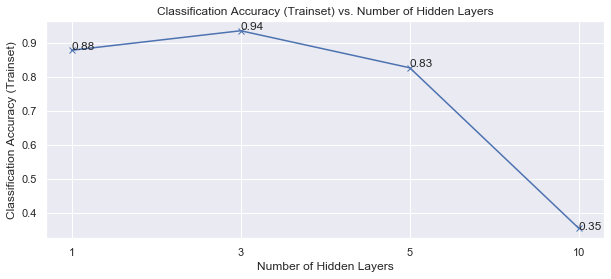

In [34]:
x = [1, 3, 5, 10]
xi = list(range(len(x)))
plt.plot(compile_model_trainset_acc, '-x')
plt.xlabel('Number of Hidden Layers')
plt.xticks(xi, x)
plt.ylabel('Classification Accuracy (Trainset)')
plt.title('Classification Accuracy (Trainset) vs. Number of Hidden Layers');

for i, txt in enumerate(compile_model_trainset_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
    
plt.show()

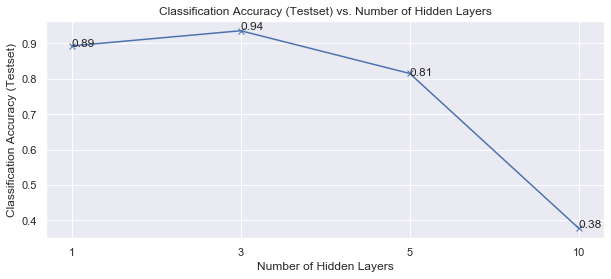

In [35]:
x = [1, 3, 5, 10]
xi = list(range(len(x)))
plt.plot(compile_model_testset_acc, '-x')
plt.xlabel('Number of Hidden Layers')
plt.xticks(xi, x)
plt.ylabel('Classification Accuracy (Testset)')
plt.title('Classification Accuracy (Testset) vs. Number of Hidden Layers');

for i, txt in enumerate(compile_model_testset_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

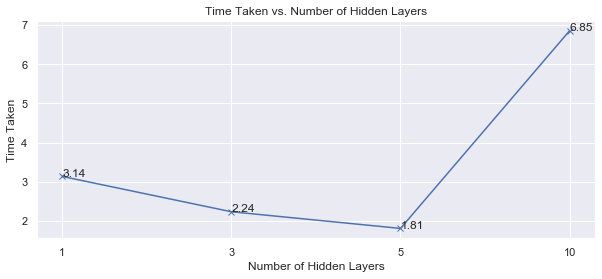

In [36]:
x = [1, 3, 5, 10]
xi = list(range(len(x)))
plt.plot(compile_model_time_to_train, '-x')
plt.xlabel('Number of Hidden Layers')
plt.xticks(xi, x)
plt.ylabel('Time Taken')
plt.title('Time Taken vs. Number of Hidden Layers');

for i, txt in enumerate(compile_model_time_to_train):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

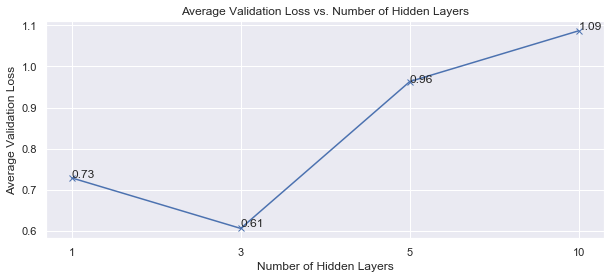

In [37]:
x = [1, 3, 5, 10]
xi = list(range(len(x)))
plt.plot(compile_avg_model_loss, '-x')
plt.xlabel('Number of Hidden Layers')
plt.xticks(xi, x)
plt.ylabel('Average Validation Loss')
plt.title('Average Validation Loss vs. Number of Hidden Layers');

for i, txt in enumerate(compile_avg_model_loss):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

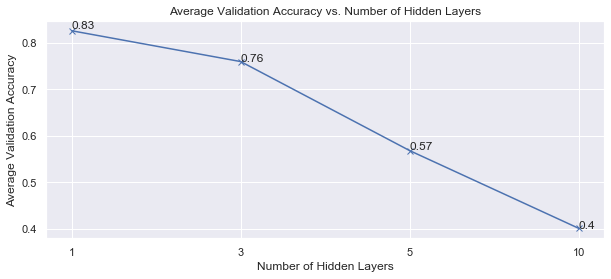

In [38]:
x = [1, 3, 5, 10]
xi = list(range(len(x)))
plt.plot(compile_avg_model_acc, '-x')
plt.xlabel('Number of Hidden Layers')
plt.xticks(xi, x)
plt.ylabel('Average Validation Accuracy')
plt.title('Average Validation Accuracy vs. Number of Hidden Layers');

for i, txt in enumerate(compile_avg_model_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

### Task 3 (Learning Rates)

You are asked to study the effect of learning rates. As with Task 2, your experiments have to be well documented. You need to give correct conclusion and give suggestion how learning rates should be
set. This includes possible adaptive learning rates where the value increases or decreases as the
increase of epochs. 

Note that your analysis should touch the issue of accuracy as well as complexity for task 2-4. The
complexity can be defined in the context of execution time. 

In [39]:
"""
We will be using the three_layer_forward_feed_network used in task 1

Iterate through values 1 to 20 to get 0.1 - 2 as the learning rate and for that particular iteration. 
For each iteration, fit and train the model with the respective learning rate values
"""

input_size = 48
hidden_size = 100
num_classes = 3

compile_avg_model_loss = []
compile_avg_model_acc = []
compile_model_trainset_acc = []
compile_model_testset_acc = []
compile_model_time_to_train = []


for a in range(1, 21):
    
    avg_model_loss = []
    avg_model_acc = []
    time_to_train = []
    
    train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
    model = three_layer_forward_feed_neural_network(input_size, hidden_size, hidden_size, num_classes)

    history = [evaluate(model, val_loader)]

    history += fit(20, a/10, model, train_loader, val_loader, average_loss = avg_model_loss, average_acc = avg_model_acc, time_taken = time_to_train)
                   
    train_actual = []
    train_pred = []

    for i in train:
        train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        train_actual.append(int(i[48]))

    print("Train set accuracy: " + str(accuracy_score(train_actual, train_pred)))    
                   
    test_actual = []
    test_pred = []

    for i in test:
        test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        test_actual.append(int(i[48]))

    print("Test set accuracy: " + str(accuracy_score(test_actual, test_pred)))

    compile_avg_model_loss.append(avg_model_loss[0])
    compile_avg_model_acc.append(avg_model_acc[0])
    compile_model_trainset_acc.append(accuracy_score(train_actual, train_pred))
    compile_model_testset_acc.append(accuracy_score(test_actual, test_pred))
    compile_model_time_to_train.append(time_to_train[0])

Epoch [0], val_loss: 1.0723, val_acc: 0.4058
Epoch [1], val_loss: 1.0614, val_acc: 0.6329
Epoch [2], val_loss: 1.0415, val_acc: 0.5314
Epoch [3], val_loss: 1.0043, val_acc: 0.6957
Epoch [4], val_loss: 0.9371, val_acc: 0.8068
Epoch [5], val_loss: 0.8309, val_acc: 0.8406
Epoch [6], val_loss: 0.7248, val_acc: 0.7681
Epoch [7], val_loss: 0.9012, val_acc: 0.3671
Epoch [8], val_loss: 0.5013, val_acc: 0.9082
Epoch [9], val_loss: 0.6355, val_acc: 0.6763
Epoch [10], val_loss: 0.4347, val_acc: 0.8744
Epoch [11], val_loss: 0.3697, val_acc: 0.9179
Epoch [12], val_loss: 0.3783, val_acc: 0.8937
Epoch [13], val_loss: 0.8172, val_acc: 0.5169
Epoch [14], val_loss: 0.2513, val_acc: 0.9372
Epoch [15], val_loss: 0.3718, val_acc: 0.8454
Epoch [16], val_loss: 0.2362, val_acc: 0.9082
Epoch [17], val_loss: 0.1805, val_acc: 0.9710
Epoch [18], val_loss: 0.2395, val_acc: 0.9372
Epoch [19], val_loss: 0.2949, val_acc: 0.8551
Average model loss during fitting: 0.614223013818264
Average model accuracy during fitting

Epoch [6], val_loss: 0.8878, val_acc: 0.8068
Epoch [7], val_loss: 0.9648, val_acc: 0.4155
Epoch [8], val_loss: 1.0040, val_acc: 0.6087
Epoch [9], val_loss: 0.9222, val_acc: 0.6232
Epoch [10], val_loss: 0.9678, val_acc: 0.5797
Epoch [11], val_loss: 3.6850, val_acc: 0.2319
Epoch [12], val_loss: 1.0976, val_acc: 0.4010
Epoch [13], val_loss: 1.0722, val_acc: 0.4010
Epoch [14], val_loss: 1.0807, val_acc: 0.3671
Epoch [15], val_loss: 1.0480, val_acc: 0.4010
Epoch [16], val_loss: 0.9582, val_acc: 0.3913
Epoch [17], val_loss: 1.0815, val_acc: 0.3382
Epoch [18], val_loss: 1.0685, val_acc: 0.3671
Epoch [19], val_loss: 1.0442, val_acc: 0.4010
Average model loss during fitting: 1.1493383079767228
Average model accuracy during fitting: 0.46376811861991885
Time taken to fit: 4.405869007110596
Train set accuracy: 0.3534158149542765
Test set accuracy: 0.37697516930022573
Epoch [0], val_loss: 1.0793, val_acc: 0.4106
Epoch [1], val_loss: 1.0363, val_acc: 0.4879
Epoch [2], val_loss: 1.0471, val_acc: 0.40

Epoch [13], val_loss: 1.0786, val_acc: 0.3671
Epoch [14], val_loss: 1.0859, val_acc: 0.4010
Epoch [15], val_loss: 1.0832, val_acc: 0.4010
Epoch [16], val_loss: 1.0916, val_acc: 0.3671
Epoch [17], val_loss: 1.0897, val_acc: 0.3671
Epoch [18], val_loss: 1.0914, val_acc: 0.4010
Epoch [19], val_loss: 1.0935, val_acc: 0.4010
Average model loss during fitting: 1.1289087176322936
Average model accuracy during fitting: 0.38236716091632844
Time taken to fit: 4.236522197723389
Train set accuracy: 0.3534158149542765
Test set accuracy: 0.37697516930022573
Epoch [0], val_loss: 1.0406, val_acc: 0.4300
Epoch [1], val_loss: 1.0533, val_acc: 0.2754
Epoch [2], val_loss: 1.0788, val_acc: 0.4010
Epoch [3], val_loss: 1.1302, val_acc: 0.3671
Epoch [4], val_loss: 1.0932, val_acc: 0.2319
Epoch [5], val_loss: 1.0837, val_acc: 0.4010
Epoch [6], val_loss: 1.0823, val_acc: 0.4010
Epoch [7], val_loss: 1.0323, val_acc: 0.5121
Epoch [8], val_loss: 1.0838, val_acc: 0.4010
Epoch [9], val_loss: 1.0851, val_acc: 0.3671


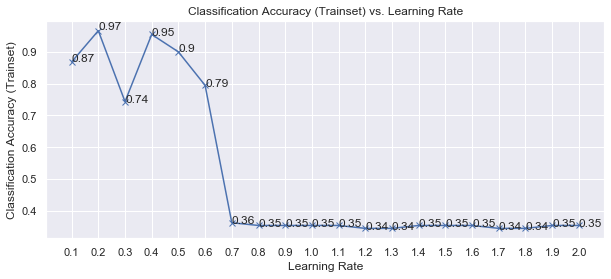

In [40]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
xi = list(range(len(x)))
plt.plot(compile_model_trainset_acc, '-x')
plt.xlabel('Learning Rate')
plt.xticks(xi, x)
plt.ylabel('Classification Accuracy (Trainset)')
plt.title('Classification Accuracy (Trainset) vs. Learning Rate');

for i, txt in enumerate(compile_model_trainset_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
    
plt.show()

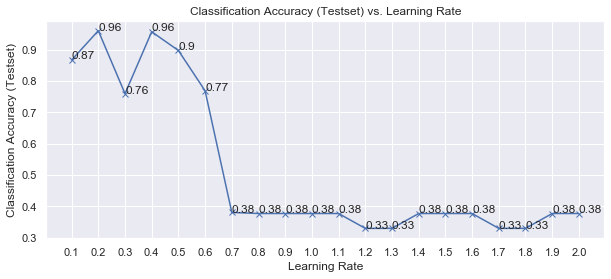

In [41]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
xi = list(range(len(x)))
plt.plot(compile_model_testset_acc, '-x')
plt.xlabel('Learning Rate')
plt.xticks(xi, x)
plt.ylabel('Classification Accuracy (Testset)')
plt.title('Classification Accuracy (Testset) vs. Learning Rate');

for i, txt in enumerate(compile_model_testset_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

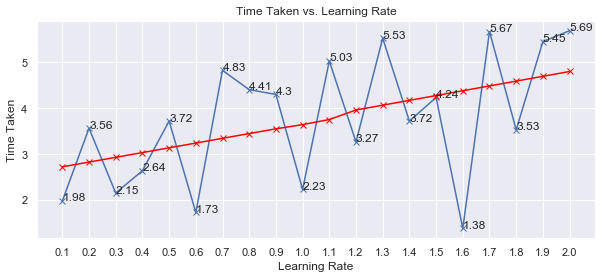

In [42]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
xi = list(range(len(x)))
plt.plot(compile_model_time_to_train, '-x')
plt.xlabel('Learning Rate')
plt.xticks(xi, x)
plt.ylabel('Time Taken')
plt.title('Time Taken vs. Learning Rate');

yhat = savgol_filter(compile_model_time_to_train, 17, 1) 
plt.plot(yhat, '-x', color='red')

for i, txt in enumerate(compile_model_time_to_train):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

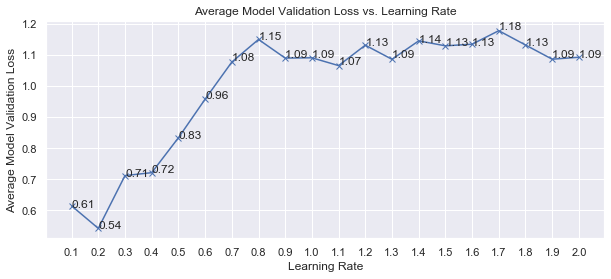

In [43]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
xi = list(range(len(x)))
plt.plot(compile_avg_model_loss, '-x')
plt.xlabel('Learning Rate')
plt.xticks(xi, x)
plt.ylabel('Average Model Validation Loss')
plt.title('Average Model Validation Loss vs. Learning Rate');

for i, txt in enumerate(compile_avg_model_loss):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

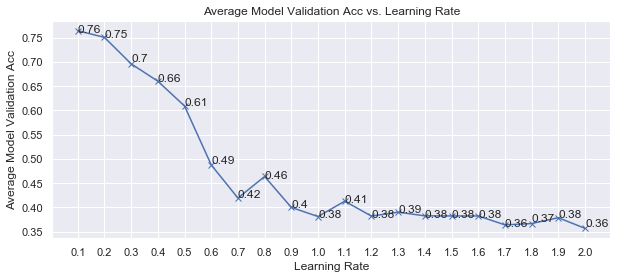

In [44]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
xi = list(range(len(x)))
plt.plot(compile_avg_model_acc, '-x')
plt.xlabel('Learning Rate')
plt.xticks(xi, x)
plt.ylabel('Average Model Validation Acc')
plt.title('Average Model Validation Acc vs. Learning Rate');

for i, txt in enumerate(compile_avg_model_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))

plt.show()

In [45]:
"""
We will be using the three_layer_forward_feed_network used in task 1

Iterate through values 1 to 30 to get the number of epochs for that particular iteration. 
For each iteration, fit and train the model with the respective number of epochs
"""

input_size = 48
hidden_size = 100
num_classes = 3

compile_avg_model_loss = []
compile_avg_model_acc = []
compile_model_trainset_acc = []
compile_model_testset_acc = []
compile_model_time_to_train = []


for a in range(1, 31):
    
    avg_model_loss = []
    avg_model_acc = []
    time_to_train = []
    
    train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(validation, BATCH_SIZE*2, num_workers=0, pin_memory=True)
    model = three_layer_forward_feed_neural_network(input_size, hidden_size, hidden_size, num_classes)

    history = [evaluate(model, val_loader)]

    history += fit(a, 0.1, model, train_loader, val_loader, average_loss = avg_model_loss, average_acc = avg_model_acc, time_taken = time_to_train)
                   
    train_actual = []
    train_pred = []

    for i in train:
        train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        train_actual.append(int(i[48]))

    print("Train set accuracy: " + str(accuracy_score(train_actual, train_pred)))    
                   
    test_actual = []
    test_pred = []

    for i in test:
        test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        test_actual.append(int(i[48]))

    print("Test set accuracy: " + str(accuracy_score(test_actual, test_pred)))

    compile_avg_model_loss.append(avg_model_loss[0])
    compile_avg_model_acc.append(avg_model_acc[0])
    compile_model_trainset_acc.append(accuracy_score(train_actual, train_pred))
    compile_model_testset_acc.append(accuracy_score(test_actual, test_pred))
    compile_model_time_to_train.append(time_to_train[0])

Epoch [0], val_loss: 1.0764, val_acc: 0.4976
Average model loss during fitting: 1.0763710737228394
Average model accuracy during fitting: 0.4975845515727997
Time taken to fit: 0.3256392478942871
Train set accuracy: 0.42764927380311996
Test set accuracy: 0.4345372460496614
Epoch [0], val_loss: 1.0774, val_acc: 0.3961
Epoch [1], val_loss: 1.0682, val_acc: 0.4734
Average model loss during fitting: 1.0728172063827515
Average model accuracy during fitting: 0.43478260934352875
Time taken to fit: 0.27703213691711426
Train set accuracy: 0.43571812802582033
Test set accuracy: 0.4492099322799097
Epoch [0], val_loss: 1.0856, val_acc: 0.4155
Epoch [1], val_loss: 1.0691, val_acc: 0.5459
Epoch [2], val_loss: 1.0548, val_acc: 0.5556
Average model loss during fitting: 1.0698121388753254
Average model accuracy during fitting: 0.505636086066564
Time taken to fit: 0.206467866897583
Train set accuracy: 0.5352339967724583
Test set accuracy: 0.5259593679458239
Epoch [0], val_loss: 1.0814, val_acc: 0.5121
Ep

Epoch [7], val_loss: 0.6010, val_acc: 0.9227
Epoch [8], val_loss: 0.7122, val_acc: 0.5121
Epoch [9], val_loss: 0.7049, val_acc: 0.6280
Epoch [10], val_loss: 0.4444, val_acc: 0.8841
Epoch [11], val_loss: 0.7299, val_acc: 0.5507
Epoch [12], val_loss: 0.8481, val_acc: 0.4879
Epoch [13], val_loss: 0.3319, val_acc: 0.9179
Epoch [14], val_loss: 0.2431, val_acc: 0.9662
Average model loss during fitting: 0.7573021401961645
Average model accuracy during fitting: 0.7082125584284464
Time taken to fit: 5.99554181098938
Train set accuracy: 0.9429800968262507
Test set accuracy: 0.9514672686230248
Epoch [0], val_loss: 1.0755, val_acc: 0.5507
Epoch [1], val_loss: 1.0609, val_acc: 0.4541
Epoch [2], val_loss: 1.0420, val_acc: 0.6377
Epoch [3], val_loss: 1.0098, val_acc: 0.7053
Epoch [4], val_loss: 0.9401, val_acc: 0.6618
Epoch [5], val_loss: 0.8539, val_acc: 0.7585
Epoch [6], val_loss: 0.7110, val_acc: 0.7971
Epoch [7], val_loss: 0.7798, val_acc: 0.5749
Epoch [8], val_loss: 0.7114, val_acc: 0.5362
Epoch

Epoch [0], val_loss: 1.0723, val_acc: 0.4251
Epoch [1], val_loss: 1.0588, val_acc: 0.4300
Epoch [2], val_loss: 1.0428, val_acc: 0.5314
Epoch [3], val_loss: 1.0036, val_acc: 0.7826
Epoch [4], val_loss: 0.9378, val_acc: 0.7101
Epoch [5], val_loss: 0.8336, val_acc: 0.7923
Epoch [6], val_loss: 0.7219, val_acc: 0.8357
Epoch [7], val_loss: 1.1069, val_acc: 0.2657
Epoch [8], val_loss: 0.5397, val_acc: 0.8116
Epoch [9], val_loss: 0.5368, val_acc: 0.8068
Epoch [10], val_loss: 0.4098, val_acc: 0.9130
Epoch [11], val_loss: 0.4167, val_acc: 0.9082
Epoch [12], val_loss: 0.5403, val_acc: 0.7053
Epoch [13], val_loss: 0.3020, val_acc: 0.9227
Epoch [14], val_loss: 0.3324, val_acc: 0.9082
Epoch [15], val_loss: 0.3515, val_acc: 0.8647
Epoch [16], val_loss: 0.3784, val_acc: 0.8164
Epoch [17], val_loss: 0.2132, val_acc: 0.9227
Epoch [18], val_loss: 0.1867, val_acc: 0.9565
Epoch [19], val_loss: 0.2085, val_acc: 0.9807
Epoch [20], val_loss: 0.1818, val_acc: 0.9710
Epoch [21], val_loss: 0.1891, val_acc: 0.922

Train set accuracy: 0.9585798816568047
Test set accuracy: 0.9582392776523702
Epoch [0], val_loss: 1.0747, val_acc: 0.5894
Epoch [1], val_loss: 1.0585, val_acc: 0.6473
Epoch [2], val_loss: 1.0346, val_acc: 0.5217
Epoch [3], val_loss: 0.9863, val_acc: 0.7391
Epoch [4], val_loss: 0.9234, val_acc: 0.8502
Epoch [5], val_loss: 0.7828, val_acc: 0.8551
Epoch [6], val_loss: 0.6743, val_acc: 0.8164
Epoch [7], val_loss: 0.7119, val_acc: 0.5266
Epoch [8], val_loss: 0.5692, val_acc: 0.7246
Epoch [9], val_loss: 0.5024, val_acc: 0.8357
Epoch [10], val_loss: 0.7986, val_acc: 0.4928
Epoch [11], val_loss: 0.3870, val_acc: 0.8841
Epoch [12], val_loss: 0.3521, val_acc: 0.9324
Epoch [13], val_loss: 0.6355, val_acc: 0.6280
Epoch [14], val_loss: 0.2897, val_acc: 0.9469
Epoch [15], val_loss: 0.2932, val_acc: 0.9130
Epoch [16], val_loss: 0.4093, val_acc: 0.7874
Epoch [17], val_loss: 0.3822, val_acc: 0.8599
Epoch [18], val_loss: 0.2151, val_acc: 0.9517
Epoch [19], val_loss: 0.1813, val_acc: 0.9565
Epoch [20], v

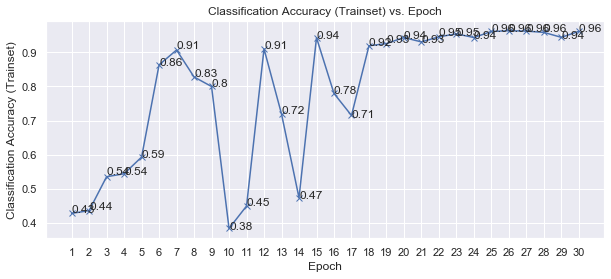

In [46]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
xi = list(range(len(x)))
plt.plot(compile_model_trainset_acc, '-x')
plt.xlabel('Epoch')
plt.xticks(xi, x)
plt.ylabel('Classification Accuracy (Trainset)')
plt.title('Classification Accuracy (Trainset) vs. Epoch');

for i, txt in enumerate(compile_model_trainset_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
    
plt.show()

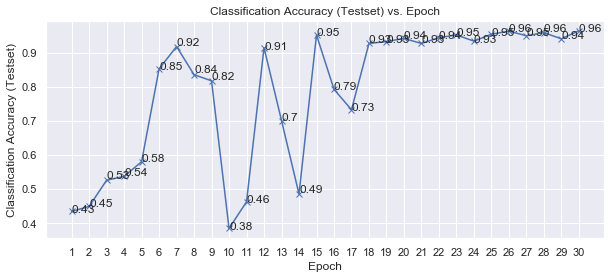

In [47]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
xi = list(range(len(x)))
plt.plot(compile_model_testset_acc, '-x')
plt.xlabel('Epoch')
plt.xticks(xi, x)
plt.ylabel('Classification Accuracy (Testset)')
plt.title('Classification Accuracy (Testset) vs. Epoch');

for i, txt in enumerate(compile_model_testset_acc):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
    
plt.show()

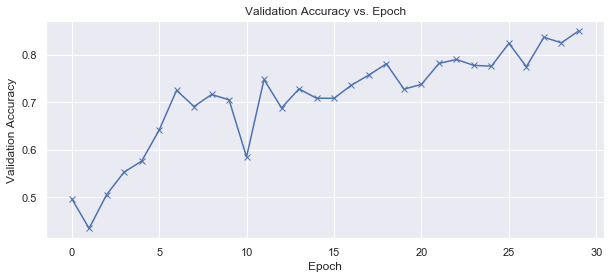

In [48]:
plt.plot(compile_avg_model_acc, '-x')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch');
plt.show()

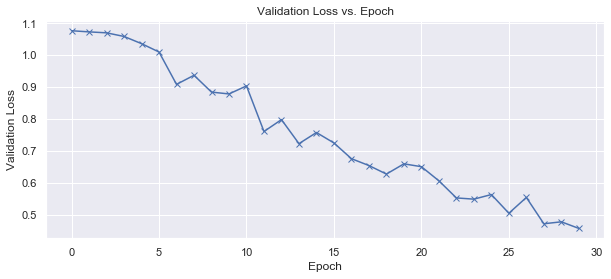

In [49]:
plt.plot(compile_avg_model_loss, '-x')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch');
plt.show()

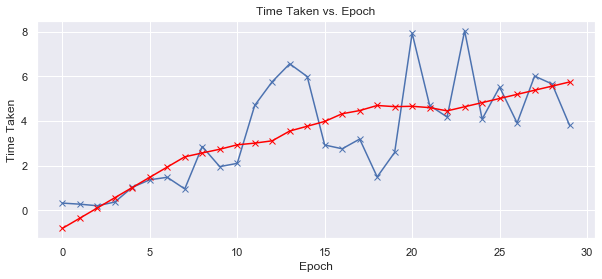

In [50]:
plt.plot(compile_model_time_to_train, '-x')
yhat = savgol_filter(compile_model_time_to_train, 15, 1) 
plt.plot(yhat, '-x', color='red')
plt.xlabel('Epoch')
plt.ylabel('Time Taken')
plt.title('Time Taken vs. Epoch');
plt.show()

### Task 4 (Mini-Batch)

You are asked to study the effect of mini-batch size. You can set mini-batch size to be 1 (stochastic
gradient descent), N (batch gradient descent) or any other size. The most important aspect is to be
conclusive with your finding. The mini-batch size really depends on the problem size. 

Note that your analysis should touch the issue of accuracy as well as complexity for task 2-4. The complexity can be defined in the context of execution time.

### [Link on Different types of Gradient Descent](https://www.analyticsvidhya.com/blog/2021/03/variants-of-gradient-descent-algorithm/)


3 types of gradient descent:


1. In batch gradient Descent, as we have seen earlier as well, we take the entire dataset > calculate the cost function > update parameter.


2. In the case of Stochastic Gradient Descent, we update the parameters after every single observation and we know that every time the weights are updated it is known as an iteration.


3. In the case of Mini-batch Gradient Descent, we take a subset of data and update the parameters based on every subset.

In [51]:
"""
SGD

MGD (10 - 100 batch size)

BGD (The entire training data set)
"""


input_size = 48
hidden_size = 100
num_classes = 3
batch_size = 1

time_to_train_model = []
average_model_validation_accuracy = []
average_model_validation_loss = []
model_test_accuracy = []
model_train_accuracy = []

history = []
train_loader = DataLoader(train, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(validation, batch_size*2, num_workers=0, pin_memory=True)
model = three_layer_forward_feed_neural_network(input_size, hidden_size, hidden_size, num_classes)
history += fit(5, 0.1, model, train_loader, val_loader, average_acc = average_model_validation_accuracy, average_loss = average_model_validation_loss, time_taken = time_to_train_model)

train_actual = []
train_pred = []

for i in train:
    train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    train_actual.append(int(i[48]))

model_train_accuracy.append(str(accuracy_score(train_actual, train_pred)))   

test_actual = []
test_pred = []

for i in test:
    test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    test_actual.append(int(i[48]))

model_test_accuracy.append(str(accuracy_score(test_actual, test_pred)))    

input_size = 48
hidden_size = 100
num_classes = 3
batch_size = [0, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for i in range (1, 16):
    history = []
    train_loader = DataLoader(train, batch_size[i], shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(validation, batch_size[i]*2, num_workers=0, pin_memory=True)
    model = three_layer_forward_feed_neural_network(input_size, hidden_size, hidden_size, num_classes)
    history += fit(5, 0.1, model, train_loader, val_loader, average_acc = average_model_validation_accuracy, average_loss = average_model_validation_loss, time_taken = time_to_train_model)

    
    train_actual = []
    train_pred = []

    for i in train:
        train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        train_actual.append(int(i[48]))
        
    model_train_accuracy.append(str(accuracy_score(train_actual, train_pred)))   
    
    test_actual = []
    test_pred = []

    for i in test:
        test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
        test_actual.append(int(i[48]))

    model_test_accuracy.append(str(accuracy_score(test_actual, test_pred)))  

input_size = 48
hidden_size = 100
num_classes = 3
batch_size = len(train)

history = []
train_loader = DataLoader(train, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(validation, batch_size*2, num_workers=0, pin_memory=True)
model = three_layer_forward_feed_neural_network(input_size, hidden_size, hidden_size, num_classes)
history += fit(5, 0.1, model, train_loader, val_loader, average_acc = average_model_validation_accuracy, average_loss = average_model_validation_loss, time_taken = time_to_train_model)

train_actual = []
train_pred = []

for i in train:
    train_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    train_actual.append(int(i[48]))

model_train_accuracy.append(str(accuracy_score(train_actual, train_pred)))   

test_actual = []
test_pred = []

for i in test:
    test_pred.append(torch.argmax(model(torch.Tensor(i[0:48]))).item())
    test_actual.append(int(i[48]))

model_test_accuracy.append(str(accuracy_score(test_actual, test_pred))) 

Epoch [0], val_loss: 0.3244, val_acc: 0.8846
Epoch [1], val_loss: 0.2148, val_acc: 0.9471
Epoch [2], val_loss: 0.0931, val_acc: 0.9712
Epoch [3], val_loss: 0.1594, val_acc: 0.9279
Epoch [4], val_loss: 0.1294, val_acc: 0.9567
Average model loss during fitting: 0.18421605825424195
Average model accuracy during fitting: 0.9375
Time taken to fit: 17.08436608314514
Epoch [0], val_loss: 0.4623, val_acc: 0.9500
Epoch [1], val_loss: 0.2759, val_acc: 0.8870
Epoch [2], val_loss: 0.1105, val_acc: 0.9682
Epoch [3], val_loss: 0.0719, val_acc: 0.9818
Epoch [4], val_loss: 0.1444, val_acc: 0.9461
Average model loss during fitting: 0.2129728987812996
Average model accuracy during fitting: 0.9466233730316163
Time taken to fit: 1.1236958503723145
Epoch [0], val_loss: 0.8845, val_acc: 0.8250
Epoch [1], val_loss: 0.9091, val_acc: 0.4268
Epoch [2], val_loss: 0.7024, val_acc: 0.6464
Epoch [3], val_loss: 0.1821, val_acc: 0.9345
Epoch [4], val_loss: 0.1457, val_acc: 0.9667
Average model loss during fitting: 0.

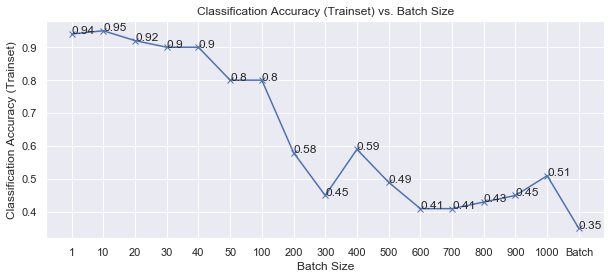

In [52]:
x = ["1", "10", "20", "30", "40", "50", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "Batch"]
y = [round(float(i), 2) for i in model_train_accuracy]
plt.plot(x, y, '-x')
plt.xlabel('Batch Size')

plt.ylabel('Classification Accuracy (Trainset)')
plt.title('Classification Accuracy (Trainset) vs. Batch Size');
for i, txt in enumerate(y):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
plt.show()

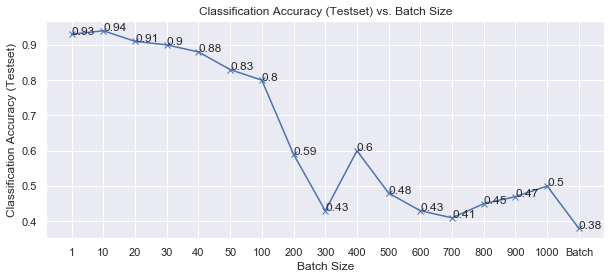

In [53]:
x = ["1", "10", "20", "30", "40", "50", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "Batch"]
y = [round(float(i), 2) for i in model_test_accuracy]
plt.plot(x, y, '-x')
plt.xlabel('Batch Size')

plt.ylabel('Classification Accuracy (Testset)')
plt.title('Classification Accuracy (Testset) vs. Batch Size');
for i, txt in enumerate(y):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
plt.show()

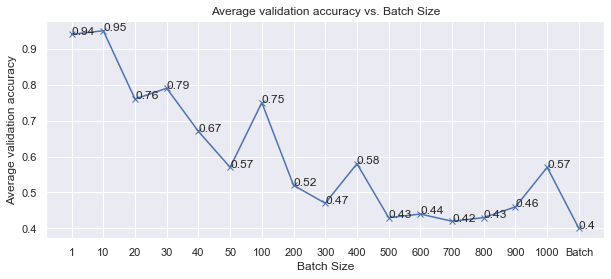

In [54]:
x = ["1", "10", "20", "30", "40", "50", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "Batch"]
y = [round(float(i), 2) for i in average_model_validation_accuracy]
plt.plot(x, y, '-x')
plt.xlabel('Batch Size')

plt.ylabel('Average validation accuracy')
plt.title('Average validation accuracy vs. Batch Size');
for i, txt in enumerate(y):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
plt.show()

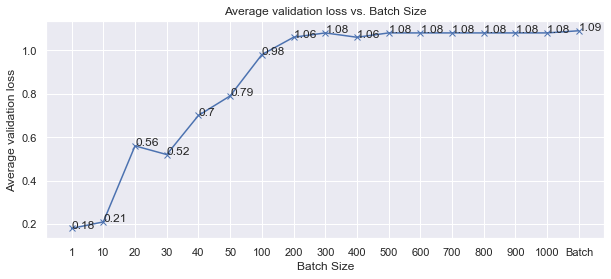

In [55]:
x = ["1", "10", "20", "30", "40", "50", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "Batch"]
y = [round(float(i), 2) for i in average_model_validation_loss]
plt.plot(x, y, '-x')
plt.xlabel('Batch Size')

plt.ylabel('Average validation loss')
plt.title('Average validation loss vs. Batch Size');
for i, txt in enumerate(y):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
plt.show()

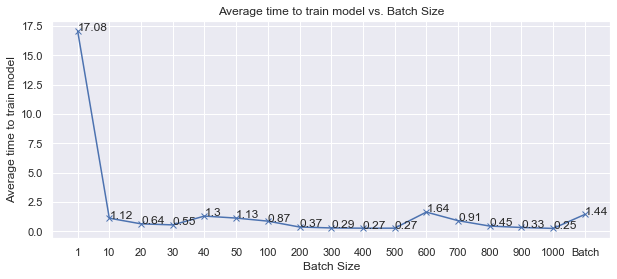

In [56]:
x = ["1", "10", "20", "30", "40", "50", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "Batch"]
y = [round(float(i), 2) for i in time_to_train_model]
plt.plot(x, y, '-x')
plt.xlabel('Batch Size')

plt.ylabel('Average time to train model')
plt.title('Average time to train model vs. Batch Size');
for i, txt in enumerate(y):
    plt.annotate(round(txt, 2), (i, round(txt, 2)))
plt.show()

## References

https://github.com/pytorch/pytorch/issues/14224

https://stackoverflow.com/questions/60440292/runtimeerror-expected-scalar-type-long-but-found-float 

https://github.com/pytorch/pytorch/issues/40388

https://analyticsindiamag.com/all-pytorch-loss-function/

https://jovian.ai/aakashns/04-feedforward-nn# https://gist.github.com/devanshuDesai/9f06681d8939afd04f8fab5ac5f5dbf8

https://jovian.ai/aakashns/04-feedforward-nn

https://www.youtube.com/watch?v=GIsg-ZUy0MY&t=5412s

https://stackoverflow.com/questions/66337378/mat1-and-mat2-shapes-cannot-be-multiplied

https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ

https://stackoverflow.com/questions/44813601/how-to-set-x-axis-values-in-matplotlib-python

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

https://xzz201920.medium.com/activation-functions-linear-non-linear-in-deep-learning-relu-sigmoid-softmax-swish-leaky-relu-a6333be712ea

https://discuss.pytorch.org/t/what-step-backward-and-zero-grad-do/33301

https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html

https://www.analyticsvidhya.com/blog/2021/03/variants-of-gradient-descent-algorithm/

https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

https://arxiv.org/abs/1605.07146

https://ojs.aaai.org/index.php/AAAI/article/view/10243/10102

https://stats.stackexchange.com/questions/303857/explanation-of-spikes-in-training-loss-vs-iterations-with-adam-optimizer

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/

https://ieeexplore.ieee.org/document/686018

https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/

https://towardsdatascience.com/what-are-overfitting-and-underfitting-in-machine-learning-a96b30864690

https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/

https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html

https://ieeexplore.ieee.org/document/9318195

https://medium.com/@kumaranupam2020/difference-between-batch-gradient-descent-bgd-minibatch-gradient-descent-mgd-and-stochastic-657efcb4194b
